In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
open('names.txt', 'r').read()[:500]

'emma\nolivia\nava\nisabella\nsophia\ncharlotte\nmia\namelia\nharper\nevelyn\nabigail\nemily\nelizabeth\nmila\nella\navery\nsofia\ncamila\naria\nscarlett\nvictoria\nmadison\nluna\ngrace\nchloe\npenelope\nlayla\nriley\nzoey\nnora\nlily\neleanor\nhannah\nlillian\naddison\naubrey\nellie\nstella\nnatalie\nzoe\nleah\nhazel\nviolet\naurora\nsavannah\naudrey\nbrooklyn\nbella\nclaire\nskylar\nlucy\npaisley\neverly\nanna\ncaroline\nnova\ngenesis\nemilia\nkennedy\nsamantha\nmaya\nwillow\nkinsley\nnaomi\naaliyah\nelena\nsarah\nariana\nallison\ngabriella\nalice\nmadelyn\ncora\nru'

In [4]:
len(words)

32033

In [5]:
print(set(''.join(words)))

{'m', 'd', 'b', 'u', 'k', 'h', 'y', 'w', 't', 'o', 's', 'f', 'j', 'n', 'i', 'a', 'q', 'p', 'z', 'x', 'l', 'r', 'v', 'e', 'c', 'g'}


In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
[0] * 3

[0, 0, 0]

In [8]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [9]:
n_embd = 10 # no of dimensions each character will have after embedding
n_hidden = 200 # no of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * ((5/3) / (n_embd*block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.001
b2 = torch.randn(vocab_size, generator=g) * 0

# the following prameters will allow backprop to control batch norm.
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print("Total params: ", sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

Total params:  12297


In [10]:
# kaiming init
((5/3) / (n_embd*block_size)**0.5)

0.3042903097250923

In [12]:
max_steps = 200000
batch_size = 32
losses = []
steps = []

for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward pass
    emb = C[Xb] # embedded the training data
    embcat = emb.view(emb.shape[0], -1)
    h_pre_act = embcat @ W1 + b1 # hidden layer + activation func.
    # batch norm.
    h_pre_act = bngain * ((h_pre_act - h_pre_act.mean(dim=0, keepdim=True)) / h_pre_act.std(dim=0, keepdim=True)) + bnbias
    h_pre_act = h_pre_act
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backprop
    for p in parameters:
        p.grad = None
    loss.backward()

    # updation
    lr = 0.1 if i<100000 else 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    losses.append(loss.item())
    steps.append(i)
    if i%10000 == 0:
        print(f"{i}/{max_steps}   {loss.item():.4f}")

0/200000   3.2974
10000/200000   2.2039
20000/200000   2.3172
30000/200000   2.4374
40000/200000   2.0127
50000/200000   2.2896
60000/200000   2.4485
70000/200000   2.0918
80000/200000   2.2562
90000/200000   2.1923
100000/200000   1.9478
110000/200000   2.3251
120000/200000   2.0012
130000/200000   2.4648
140000/200000   2.4478
150000/200000   2.2452
160000/200000   1.9925
170000/200000   1.8927
180000/200000   2.0509
190000/200000   1.8600


In [20]:
# batch norm.
((h_pre_act - h_pre_act.mean(dim=0, keepdim=True)) / h_pre_act.std(dim=0, keepdim=True))

tensor([[ 1.0822e+00,  1.7200e+00,  2.1314e-01,  ..., -1.5928e+00,
          1.1259e+00,  1.0464e+00],
        [ 1.1112e+00,  5.5031e-01, -9.5534e-01,  ..., -8.5557e-01,
          2.3415e+00,  8.9456e-01],
        [-3.0343e-01,  5.5340e-01, -1.6153e+00,  ...,  1.0895e+00,
         -1.1870e+00, -9.6174e-01],
        ...,
        [-6.4712e-01, -6.6592e-01, -3.9149e-01,  ...,  3.4449e-01,
         -2.4883e-03, -4.8940e-01],
        [ 6.6776e-01,  2.9956e-01,  1.0306e+00,  ..., -3.6684e-01,
         -5.9049e-01,  4.3854e-01],
        [-5.0509e-01, -1.4733e-01, -3.1791e+00,  ...,  2.0311e-01,
          4.8959e-01,  5.5848e-01]], grad_fn=<DivBackward0>)

In [13]:
embcat = emb.view(emb.shape[0], -1) # concatination 32,3,10 -> 32,30
embcat.shape, Xb.shape, emb.shape, W1.shape

(torch.Size([32, 30]),
 torch.Size([32, 3]),
 torch.Size([32, 3, 10]),
 torch.Size([30, 200]))

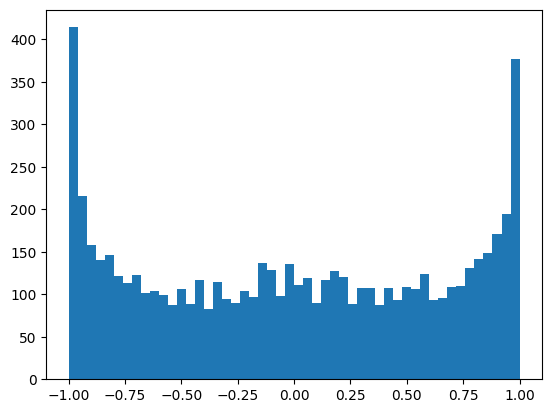

In [14]:
# checking values of h
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

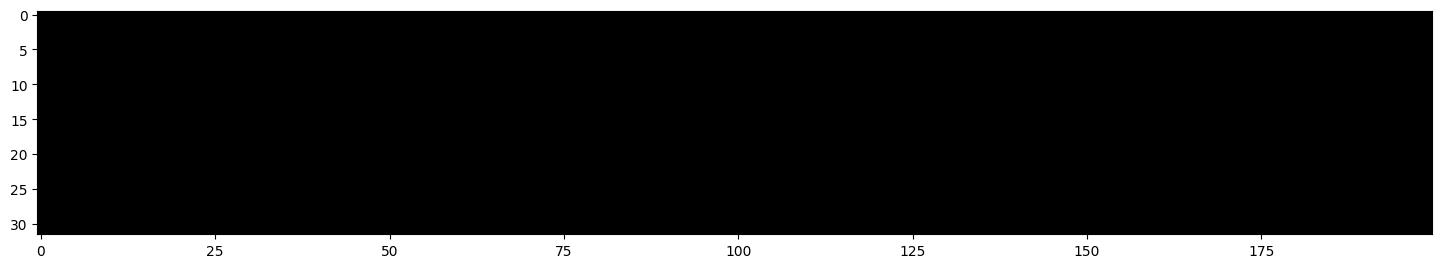

In [15]:
plt.figure(figsize=(18,10))
plt.imshow(h.abs() == 1.0, cmap='gray')

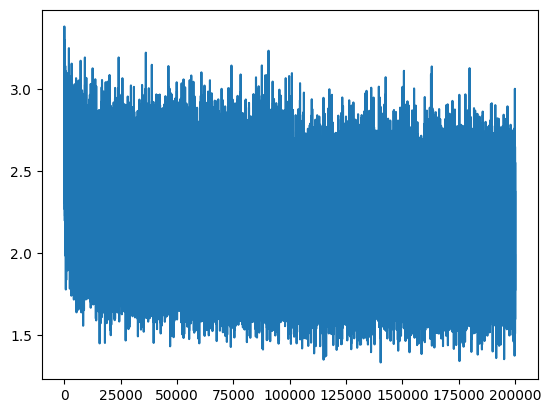

In [16]:
plt.plot(steps, losses)

In [17]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'test' : (Xte, Yte),
        'validation' : (Xdev, Ydev)
    }[split]
    emb = C[x]
    embcat = emb.view(x.shape[0], -1) # concatination
    h_pre_act = embcat @ W1 + b1
    h_pre_act = bngain * ((h_pre_act - h_pre_act.mean(dim=0, keepdim=True)) / h_pre_act.std(dim=0, keepdim=True)) + bnbias
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, " : ", loss.item())

split_loss('test')
split_loss('validation')

test  :  2.1082544326782227
validation  :  2.1075103282928467


In [18]:
# creating sample names
g = torch.Generator()
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)        
        # if ix = '.' then we break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

debianayffigh.
quslainyah.
die.
bdierrixell.
sulipslanirthell.
bububacklyssn.
grachvishntbely.
blvianayrdssaambryff.
budaliffrinishbir.
shanargunnishbrnnyushcgblllogrickllissannixtobbigh.
lecsloltdya.
dasgbyc.
blgaerekslayrds.
daldyn.
bobbigalykagghmylissa.
fumbdyo.
fgrrykshntdy.
viyamariyvangulds.
dyybiandh.
brianabdus.
